In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from cnn_utils import *
from test_utils import summary, comparator

%matplotlib inline
np.random.seed(1)

In [2]:
def load_FFHISMD_dataset():
    # Load training dataset
    train_dataset = h5py.File('datasets/train_FFHISMD.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # your train set labels

    # Load testing dataset
    test_dataset = h5py.File('datasets/test_FFHISMD.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    # Classes are still relevant for identification, but here they represent labels instead of classes
    classes = np.array(['F', 'H', 'I', 'S', 'M', 'D'])  # Adjusted to represent icons

    # Reshape labels if necessary (shape: (num_classes, num_samples))
    # Here, we keep the original shape since the labels are already in the correct format.
    # train_set_y_orig will have shape (num_samples, num_classes)
    # test_set_y_orig will also have shape (num_samples, num_classes)

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# Loading the data 
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_FFHISMD_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# No need to convert labels to one-hot; use them as they are
Y_train = Y_train_orig  # Keep the labels as multi-label vectors
Y_test = Y_test_orig

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 54900
number of test examples = 6100
X_train shape: (54900, 21, 53, 3)
Y_train shape: (54900, 7)
X_test shape: (6100, 21, 53, 3)
Y_test shape: (6100, 7)


Sample training image 33003:


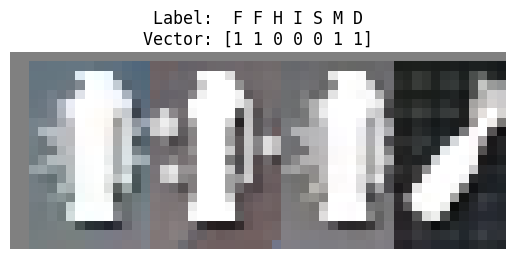

In [3]:
# Select a random index from the training dataset
index = np.random.randint(0, X_train.shape[0])  # Random index within the range of training examples
print(f'Sample training image {index}:')

# Display the sample training image
plt.imshow(X_train[index])  # Use X_train for the normalized image

# Create a label string for visualization
label_vector = Y_train[index]
label_string = "F F H I S M D"

# Set title with the label vector and aligned representation
plt.title(f'Label:  {label_string}\nVector: {label_vector}', fontdict={'family': 'monospace'})
plt.axis('off')  # Turn off axis labels
plt.show()

In [4]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_img = tf.keras.Input(shape=input_shape)
    
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tf.keras.layers.Conv2D(filters=8, kernel_size=4, strides=1, padding='same')(input_img)
    
    ## RELU
    A1 = tf.keras.layers.ReLU()(Z1)
    
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P1 = tf.keras.layers.MaxPool2D(pool_size=(5, 5), strides=(5, 5), padding='same')(A1)
    
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, padding='same')(P1)
    
    ## RELU
    A2 = tf.keras.layers.ReLU()(Z2)
    
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(3, 3), padding='same')(A2)
    
    ## FLATTEN
    F  = tf.keras.layers.Flatten()(P2)
    
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tf.keras.layers.Dense(units= 7, activation='sigmoid')(F)
    
    # YOUR CODE ENDS HERE
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [5]:
conv_model = convolutional_model((21, 53, 3))
conv_model.compile(optimizer='adam', 
                   loss='binary_crossentropy', 
                   metrics=[tf.keras.metrics.BinaryAccuracy(), 
                            tf.keras.metrics.Precision(), 
                            tf.keras.metrics.Recall()])
conv_model.summary()

# X_train = X_train[:900]
# Y_train = Y_train[:900]
# X_test = X_test[:100]
# Y_test = Y_test[:100]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 53, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 53, 8)      │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 21, 53, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 11, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 11, 16)      │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 5, 11, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,823 (7.12 KB)

 Trainable params: 1,823 (7.12 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(256)

# Fit the model to the training dataset
history = conv_model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6425 - loss: 0.6302 - precision: 0.5970 - recall: 0.3180 - val_binary_accuracy: 0.7706 - val_loss: 0.4882 - val_precision: 0.7731 - val_recall: 0.6018
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8112 - loss: 0.4290 - precision: 0.8056 - recall: 0.6956 - val_binary_accuracy: 0.9007 - val_loss: 0.2805 - val_precision: 0.9105 - val_recall: 0.8331
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9170 - loss: 0.2472 - precision: 0.9090 - recall: 0.8808 - val_binary_accuracy: 0.9501 - val_loss: 0.1744 - val_precision: 0.9519 - val_recall: 0.9217
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9573 - loss: 0.1579 - precision: 0.9492 - recall: 0.9439 - val_binary_accuracy: 0.9716 - val_loss: 0.1205 - val_precision: 0.9703 - val_recall: 0.9581
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9736 - loss: 0.1107 - precision

In [7]:
history.history

{'binary_accuracy': [0.6837677955627441,
  0.8455476760864258,
  0.9296772480010986,
  0.9626829028129578,
  0.9765232801437378,
  0.984582781791687,
  0.9890084266662598,
  0.9913008213043213,
  0.9926437139511108,
  0.993604302406311,
  0.9943326711654663,
  0.994878888130188,
  0.9953294396400452,
  0.9957147240638733,
  0.9960188865661621,
  0.9962920546531677,
  0.9965549111366272,
  0.9967861771583557,
  0.9970203638076782,
  0.9971867799758911,
  0.9973142743110657,
  0.9974209666252136,
  0.9975147247314453,
  0.997608482837677,
  0.9976968169212341,
  0.9977853298187256,
  0.9978762269020081,
  0.9979285597801208,
  0.9980065226554871,
  0.998066246509552,
  0.9981210231781006,
  0.9981732368469238,
  0.9982041716575623,
  0.9982665777206421,
  0.9982979893684387,
  0.9983475208282471,
  0.998388946056366,
  0.9984229803085327,
  0.9984592795372009,
  0.9985009431838989,
  0.9985217452049255,
  0.9985581040382385,
  0.998589277267456,
  0.9986127018928528,
  0.998625636100769,

C:\Users\Roberto Brusnicki\AppData\Local\Temp\ipykernel_25888\2103368217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)
C:\Users\Roberto Brusnicki\AppData\Local\Temp\ipykernel_25888\2103368217.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary_acc.rename(columns={'binary_accuracy': 'train', 'val_binary_accuracy': 'validation'}, inplace=True)
C:\Users\Roberto Brusnicki\AppData\Local\Temp\ipykernel_25888\2103368217.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

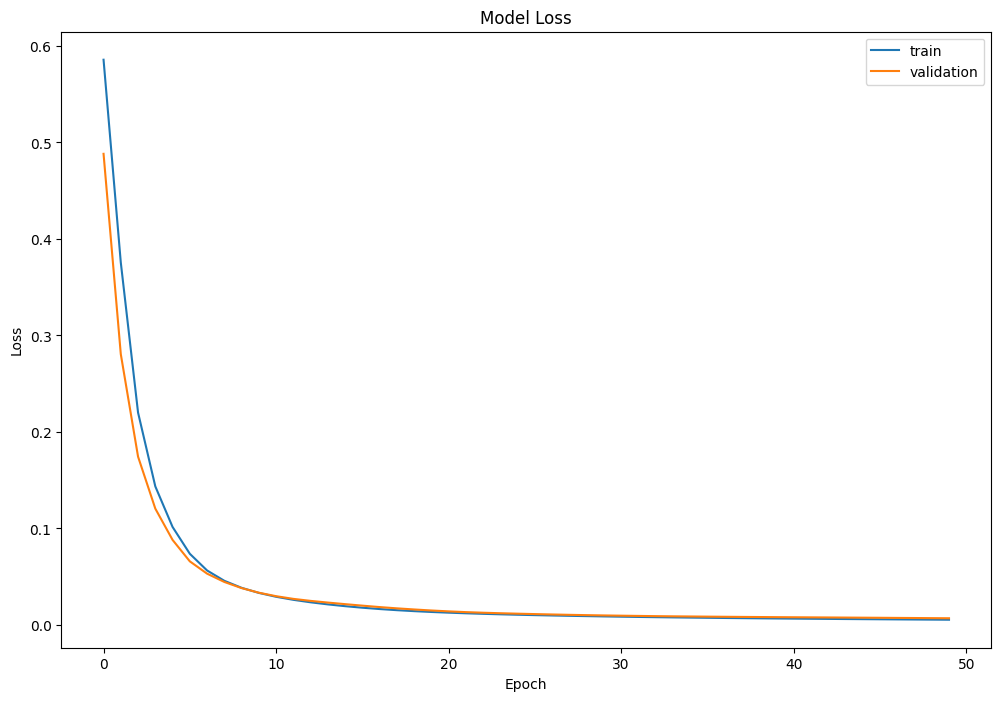

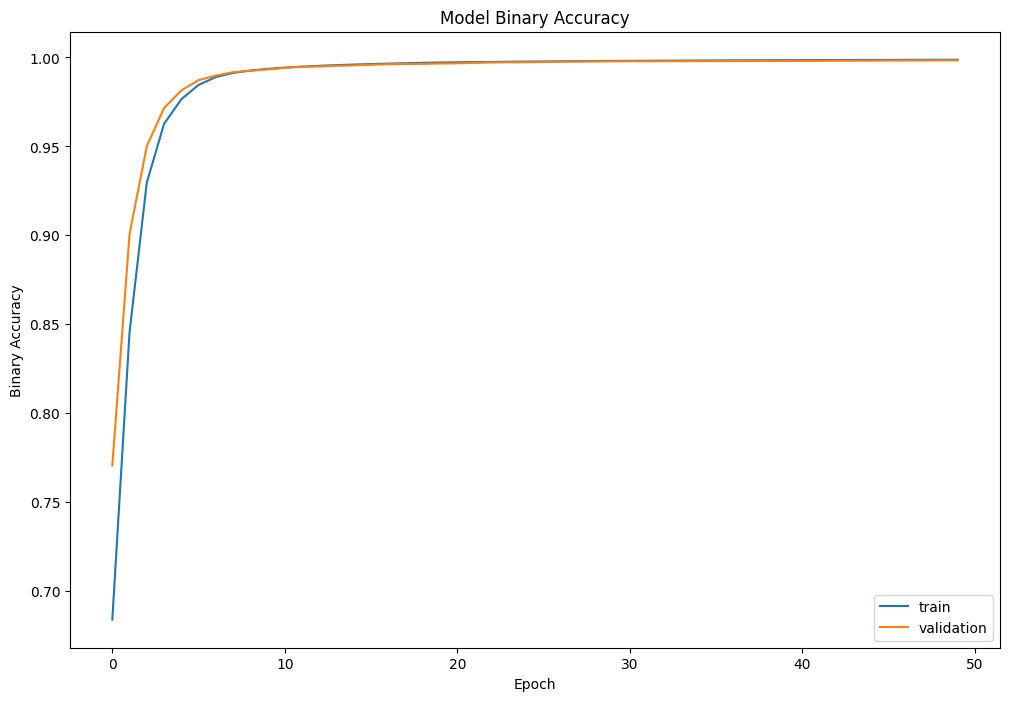

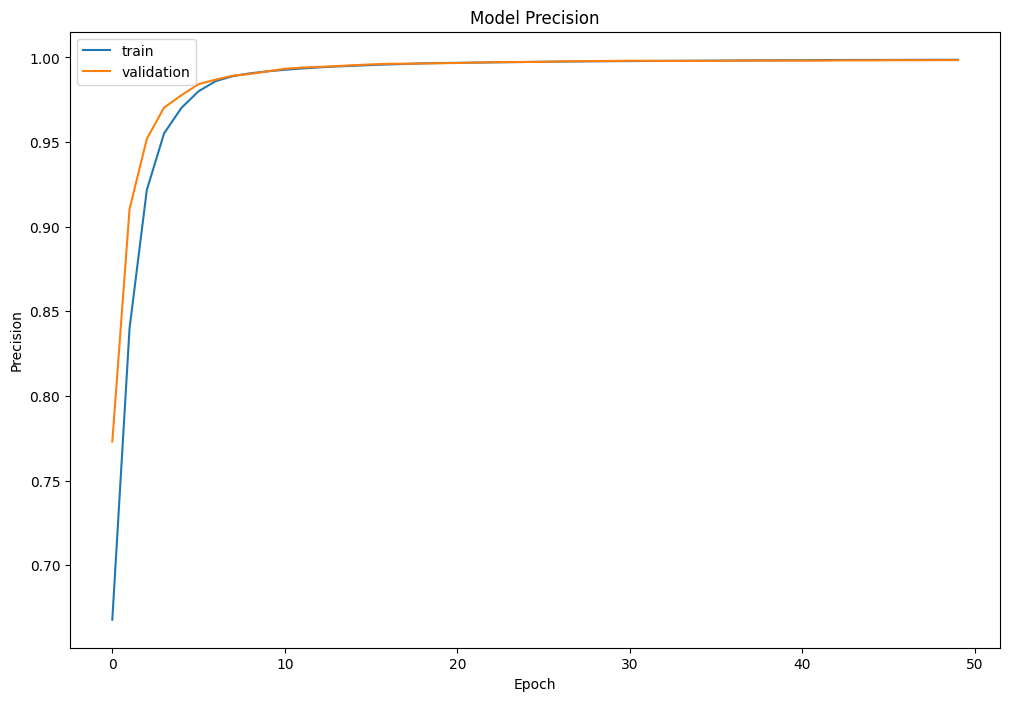

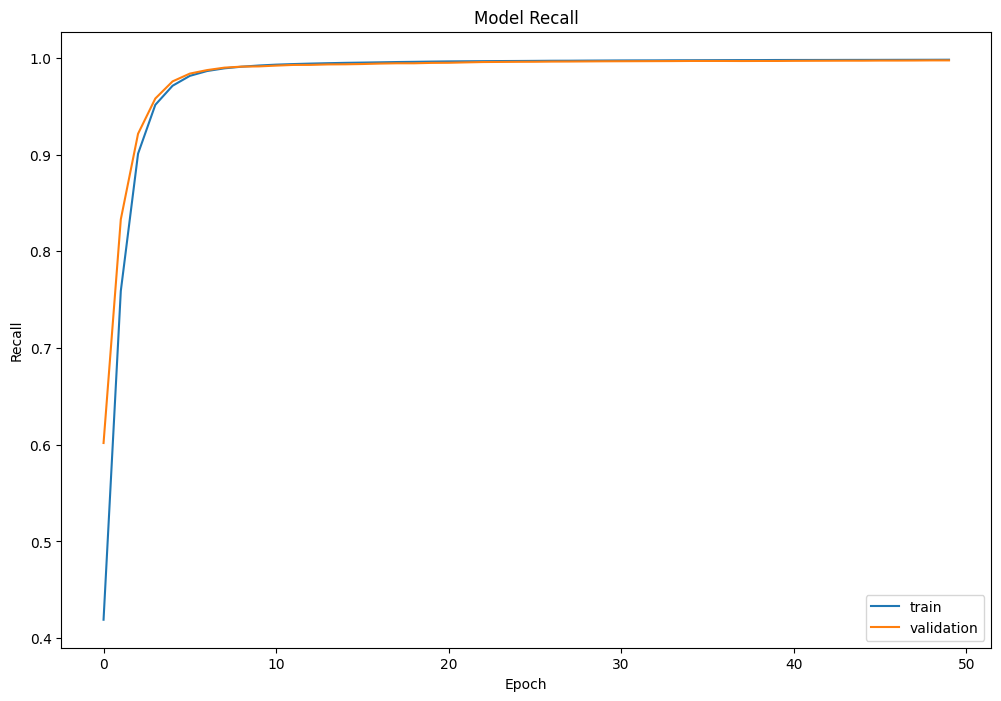

In [8]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 

# Convert history to DataFrame
df_metrics = pd.DataFrame(history.history)

# Extract loss data
df_loss = df_metrics[['loss', 'val_loss']]
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)

# Extract binary accuracy data
df_binary_acc = df_metrics[['binary_accuracy', 'val_binary_accuracy']]
df_binary_acc.rename(columns={'binary_accuracy': 'train', 'val_binary_accuracy': 'validation'}, inplace=True)

# Extract precision data
df_precision = df_metrics[['precision', 'val_precision']]
df_precision.rename(columns={'precision': 'train', 'val_precision': 'validation'}, inplace=True)

# Extract recall data
df_recall = df_metrics[['recall', 'val_recall']]
df_recall.rename(columns={'recall': 'train', 'val_recall': 'validation'}, inplace=True)

# Plotting loss
df_loss.plot(title='Model Loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')

# Plotting binary accuracy
df_binary_acc.plot(title='Model Binary Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Binary Accuracy')

# Plotting precision
df_precision.plot(title='Model Precision', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Precision')

# Plotting recall
df_recall.plot(title='Model Recall', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Recall')

plt.show()  # Ensure that all plots are displayed

In [9]:
# Save the model
conv_model.save('FFHISMD_model.keras')


<a name='4-1'></a>
### - Load the Model to test with some images


In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import random

# Load the model
model = tf.keras.models.load_model('FFHISMD_model.keras')

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(21, 53))  # Change target size as per your model's input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

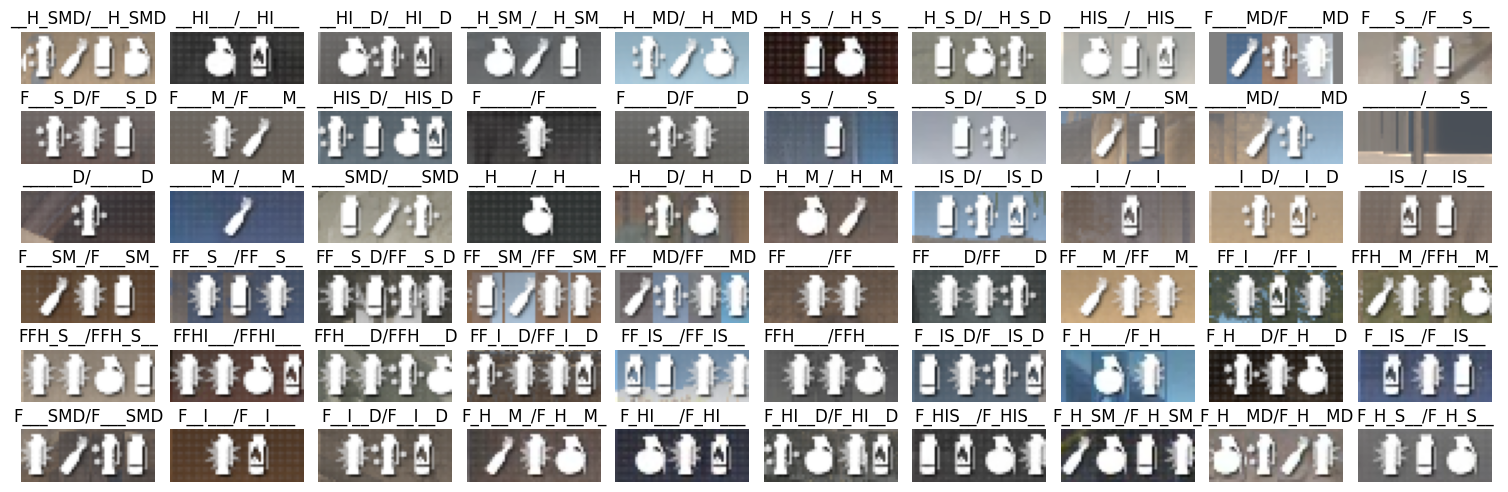

In [17]:
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# List of directories for each label (update paths accordingly)
directories = [
    'datasets/FFHISMD/__H_SMD',
    'datasets/FFHISMD/__HI___',
    'datasets/FFHISMD/__HI__D',
    'datasets/FFHISMD/__H_SM_',
    'datasets/FFHISMD/__H__MD',
    'datasets/FFHISMD/__H_S__',
    'datasets/FFHISMD/__H_S_D',
    'datasets/FFHISMD/__HIS__',
    'datasets/FFHISMD/F____MD',
    'datasets/FFHISMD/F___S__',
    'datasets/FFHISMD/F___S_D',
    'datasets/FFHISMD/F____M_',
    'datasets/FFHISMD/__HIS_D',
    'datasets/FFHISMD/F______',
    'datasets/FFHISMD/F_____D',
    'datasets/FFHISMD/____S__',
    'datasets/FFHISMD/____S_D',
    'datasets/FFHISMD/____SM_',
    'datasets/FFHISMD/_____MD',
    'datasets/FFHISMD/_______',
    'datasets/FFHISMD/______D',
    'datasets/FFHISMD/_____M_',
    'datasets/FFHISMD/____SMD',
    'datasets/FFHISMD/__H____',
    'datasets/FFHISMD/__H___D',
    'datasets/FFHISMD/__H__M_',
    'datasets/FFHISMD/___IS_D',
    'datasets/FFHISMD/___I___',
    'datasets/FFHISMD/___I__D',
    'datasets/FFHISMD/___IS__',
    'datasets/FFHISMD/F___SM_',
    'datasets/FFHISMD/FF__S__',
    'datasets/FFHISMD/FF__S_D',
    'datasets/FFHISMD/FF__SM_',
    'datasets/FFHISMD/FF___MD',
    'datasets/FFHISMD/FF_____',
    'datasets/FFHISMD/FF____D',
    'datasets/FFHISMD/FF___M_',
    'datasets/FFHISMD/FF_I___',
    'datasets/FFHISMD/FFH__M_',
    'datasets/FFHISMD/FFH_S__',
    'datasets/FFHISMD/FFHI___',
    'datasets/FFHISMD/FFH___D',
    'datasets/FFHISMD/FF_I__D',
    'datasets/FFHISMD/FF_IS__',
    'datasets/FFHISMD/FFH____',
    'datasets/FFHISMD/F__IS_D',
    'datasets/FFHISMD/F_H____',
    'datasets/FFHISMD/F_H___D',
    'datasets/FFHISMD/F__IS__',
    'datasets/FFHISMD/F___SMD',
    'datasets/FFHISMD/F__I___',
    'datasets/FFHISMD/F__I__D',
    'datasets/FFHISMD/F_H__M_',
    'datasets/FFHISMD/F_HI___',
    'datasets/FFHISMD/F_HI__D',
    'datasets/FFHISMD/F_HIS__',
    'datasets/FFHISMD/F_H_SM_',
    'datasets/FFHISMD/F_H__MD',
    'datasets/FFHISMD/F_H_S__',
    'datasets/FFHISMD/F_H_S_D',
]

# Define the grid size
grid_rows = 6
grid_cols = 10
total_images = grid_rows * grid_cols

# Create a figure for the grid
fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 5))  # Adjust size for visibility

# Loop to test one image from each directory
for i, directory in enumerate(directories):
    if i >= total_images:
        break
    
    # Get a list of images in the selected directory
    image_files = os.listdir(directory)
    
    # Randomly select an image from the directory
    selected_image = random.choice(image_files)
    
    # Construct the full path to the image
    img_path = os.path.join(directory, selected_image)
    
    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path)
    
    # Make predictions
    predictions = model.predict(img_array)
    predicted_classes = (predictions[0] > 0.5).astype(int)  # Thresholding for binary predictions
    
    # Create label string based on predicted classes
    label_str = ''.join([labels[j] if predicted_classes[j] else '_' for j in range(len(predicted_classes))])
    
    # Display the image in the grid
    ax = axs[i // grid_cols, i % grid_cols]  # Calculate position in grid
    ax.imshow(image.load_img(img_path))
    ax.set_title(f'{directory.split("/")[-1]}/{label_str}')
    ax.axis('off')  # Hide axes

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [18]:
def count_incorrect_predictions(model, X_test, Y_test):
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Initialize a counter for incorrect predictions
    incorrect_count = 0
    
    for i in range(len(predictions)):
        # Check if the prediction differs from the actual label
        if np.any(predictions[i] > 0.5) != np.any(Y_test[i] > 0.5):  # Adjust threshold as needed
            incorrect_count += 1
            
    return incorrect_count

# Count the number of incorrect predictions
num_incorrect = count_incorrect_predictions(conv_model, X_test, Y_test)
print(f"Number of incorrect predictions: {num_incorrect} out of {len(X_test)}")


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
Number of incorrect predictions: 9 out of 6100


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


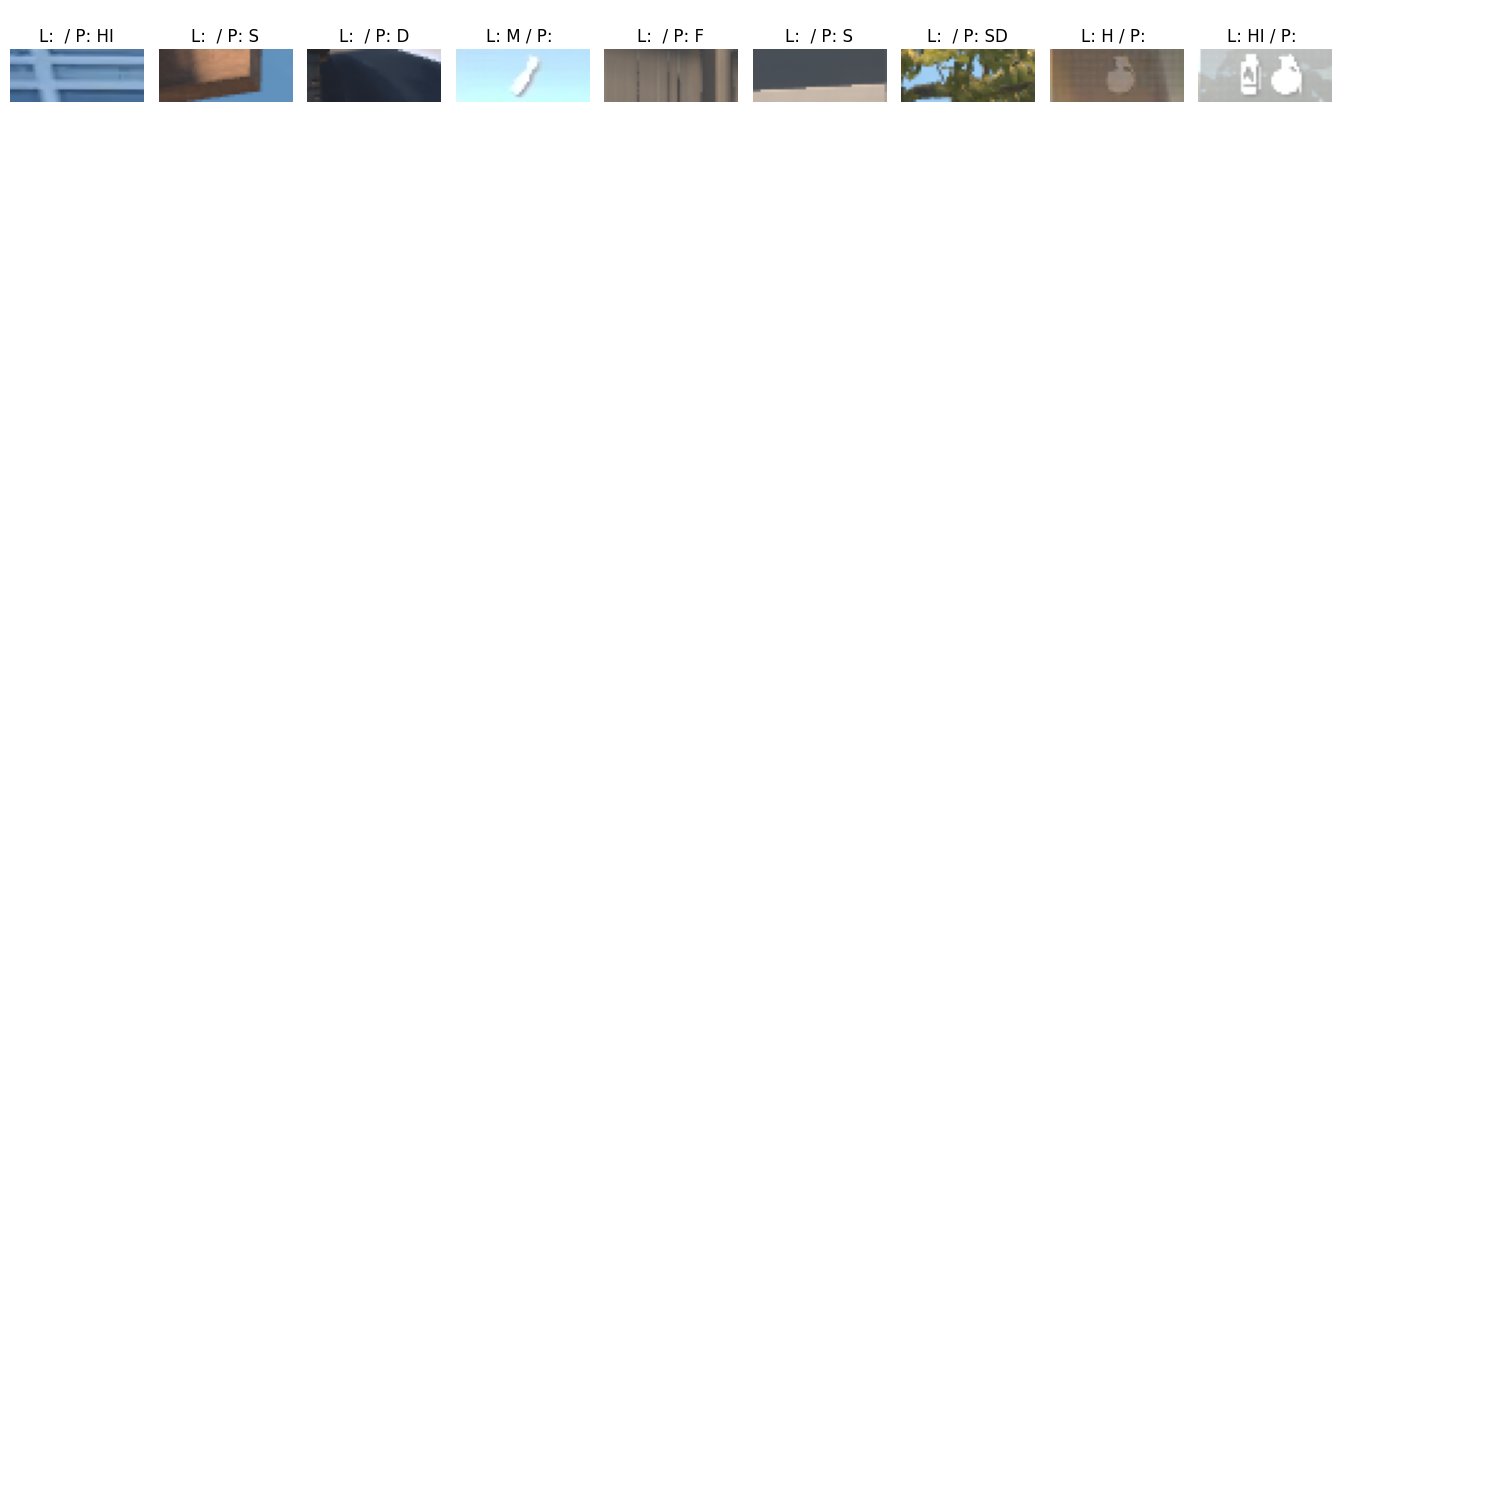

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to visualize incorrect predictions
def visualize_incorrect_predictions(model, X_test, Y_test, num_samples=9):
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Identify incorrect predictions
    incorrect_indices = []
    for i in range(len(predictions)):
        if np.any(predictions[i] > 0.5) != np.any(Y_test[i] > 0.5):  # Adjust threshold as needed
            incorrect_indices.append(i)

    # Ensure we sample at least num_samples images; if fewer incorrect predictions, fill with blanks
    sampled_indices = random.sample(incorrect_indices, min(num_samples, len(incorrect_indices)))
    # Fill remaining spaces with random correct predictions if there are fewer than num_samples incorrect ones
    if len(sampled_indices) < num_samples:
        correct_indices = [i for i in range(len(predictions)) if i not in incorrect_indices]
        sampled_indices += random.sample(correct_indices, num_samples - len(sampled_indices))
    
    # Create a figure to display the images
    fig, axs = plt.subplots(10, 10, figsize=(15, 15))  # 10 rows, 10 columns

    for i in range(100):
        ax = axs[i // 10, i % 10]  # Calculate position in grid
        
        if i < len(sampled_indices):  # Check if there is an image to display
            index = sampled_indices[i]
            ax.imshow(X_test[index])
            
            # Construct the true and predicted labels
            true_label = ''.join(['F' if Y_test[index][0] > 0.5 else '',
                                   'F' if Y_test[index][1] > 0.5 else '',
                                   'H' if Y_test[index][2] > 0.5 else '',
                                   'I' if Y_test[index][3] > 0.5 else '',
                                   'S' if Y_test[index][4] > 0.5 else '',
                                   'M' if Y_test[index][5] > 0.5 else '',
                                   'D' if Y_test[index][6] > 0.5 else ''])
            
            predicted_label = ''.join(['F' if predictions[index][0] > 0.5 else '',
                                        'F' if predictions[index][1] > 0.5 else '',
                                        'H' if predictions[index][2] > 0.5 else '',
                                        'I' if predictions[index][3] > 0.5 else '',
                                        'S' if predictions[index][4] > 0.5 else '',
                                        'M' if predictions[index][5] > 0.5 else '',
                                        'D' if predictions[index][6] > 0.5 else ''])
            
            # Set the title with true and predicted labels
            ax.set_title(f"L: {true_label} / P: {predicted_label}")
        else:
            ax.axis('off')  # Hide axes for empty plots

        ax.axis('off')  # Hide axes for all images

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Run the function to visualize incorrect predictions
visualize_incorrect_predictions(conv_model, X_test, Y_test)

